# OTICA: Operation Tango Cash

Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from openpyxl import Workbook
import re
import socket
import psutil
import plotly.express as px
import plotly.graph_objects as go 
from dash import Dash, html, dcc, dash_table, Input, Output
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import dash.dependencies as dd
from dash.dash_table.Format import Group
from plotly.subplots import make_subplots

In [2]:
# Get the current date
current_date = datetime.now()

## Getting Robinhood Portfolio

Need to copy and paste the Robinhood "Investing overview" table in the Portfolio excel file in the Portfolio sheet.   The output should be a single column with the first row being "Name."

In [11]:
# Attempt to load the "Portfolio" sheet
portfolio = pd.read_excel('Portfolio.xlsx', sheet_name='Portfolio')
sheet_used = 'Portfolio'

# If the DataFrame is empty, load from the "Master" sheet instead
if portfolio.empty:
    portfolio = pd.read_excel('Portfolio.xlsx', sheet_name='Master')
    sheet_used = 'Master'

# Check if the "Master" sheet was loaded and skip further processing if so
if sheet_used == 'Master':
    print("Loaded sheet is 'Master'. Skipping further processing.")
else:
    # Add the column names as the first row
    portfolio.loc[-1] = portfolio.columns  # Add column names as a new row
    portfolio.index = portfolio.index + 1  # Shift the index so that the new row becomes the first row
    portfolio = portfolio.sort_index()      # Sort index to move the new row to the top

    # Step 1: Extract column names (assuming they are in the first 7 rows of the first column)
    column_names = portfolio.iloc[:7, 0].tolist()

    # Step 2: Extract the remaining rows (data starts after the first 7 rows)
    data_rows = portfolio.iloc[7:, 0].tolist()

    # Step 3: Reshape the data into rows of length equal to the number of columns (without padding)
    num_columns = len(column_names)
    reshaped_data = [data_rows[i:i + num_columns] for i in range(0, len(data_rows), num_columns)]

    # Step 4: Create a new DataFrame with the reshaped data and set the column names
    portfolio = pd.DataFrame(reshaped_data, columns=column_names)

    # Update the 'Total return' column to add a '-' prefix when 'Average cost' is greater than 'Price'
    portfolio["Total return"] = portfolio.apply(
        lambda row: f"-{abs(row['Total return'])}" if row["Average cost"] > row["Price"] else row["Total return"], axis=1
    )

    # Create a new column 'Return %' to calculate the percentage return
    portfolio["Return %"] = ((portfolio["Price"] - portfolio["Average cost"]) / portfolio["Average cost"]) * 100
    portfolio["Return %"] = round(portfolio["Return %"], 1)

    # Calculate equity distribution for each position
    total_equity = portfolio['Equity'].sum()
    portfolio['Portfolio %'] = (portfolio['Equity'] / total_equity) * 100
    portfolio['Portfolio %'] = round(portfolio['Portfolio %'], 1)

    # Rename the 'Total return' column to 'Return'
    portfolio = portfolio.rename(columns={'Total return': 'Return'})

    # Display the first 5 rows of the final portfolio DataFrame
    print(portfolio.head())


Loaded sheet is 'Master'. Skipping further processing.


In [17]:
# Create a list of columns to remove
cols_to_drop = [col[:-2] + '_y' for col in portfolio.columns 
                if col.endswith('_x') and (col[:-2] + '_y' in portfolio.columns)]

# Drop the identified _y columns from portfolo
portfolio = portfolio.drop(columns=cols_to_drop)


In [19]:
portfolio.columns

Index(['Name', 'Symbol', 'Shares', 'Price', 'Average cost', 'Return', 'Equity',
       'Return %', 'Portfolio %', 'Total_Div',
       ...
       'technical_score_description', 'Fundamental_Signal', 'Technical_Signal',
       'Composite_Action', 'industry', 'industryKey', 'industryDisp', 'sector',
       'sectorKey', 'sectorDisp'],
      dtype='object', length=265)

## Getting Robinhood Dividend

Need to copy and paste the Robinhood "Dividend History" table in the Portfolio excel file in the Dividend sheet.  The output should be a single column with the first row being "Pending."

In [23]:
dividends = pd.read_excel('Portfolio.xlsx', sheet_name='Dividends')

# Check if dividends is empty before processing
if not dividends.empty:
    # Drop missing values
    dividends = dividends.dropna()

    # Remove rows containing 'Recent', 'Pending', or 'Older'
    dividends = dividends[~dividends.astype(str).apply(lambda x: x.str.contains('Recent|Pending|Older', case=False)).any(axis=1)]
    dividends = dividends.dropna().reset_index(drop=True)

    # Reshape data into three columns: 'Name', 'Date', 'Dividend'
    dividends = pd.DataFrame({
        'Name': dividends.iloc[0::3, 0].reset_index(drop=True),  # Every 3rd row starting from index 0
        'Date': dividends.iloc[1::3, 0].reset_index(drop=True),  # Every 3rd row starting from index 1
        'Dividend': dividends.iloc[2::3, 0].reset_index(drop=True)  # Every 3rd row starting from index 2
    })

    # Convert 'Date' column to datetime
    dividends['Date'] = pd.to_datetime(dividends['Date'], errors='coerce')

    # Convert 'Dividend' column to numeric
    dividends['Dividend'] = pd.to_numeric(dividends['Dividend'], errors='coerce')

    # Remove "Dividend from" from 'Name' column
    dividends['Name'] = dividends['Name'].str.replace('Dividend from', '', regex=False).str.strip()

    # Show the first 5 rows
    print(dividends.head(5))
else:
    print("The 'dividends' DataFrame is empty. Skipping processing.")


The 'dividends' DataFrame is empty. Skipping processing.


#### Updating Dividend History

Need to merge with dividends history to create an updated dataframe

In [27]:
dividend_history = pd.read_excel('Portfolio.xlsx', sheet_name='Dividend History' )
dividends = pd.concat([dividends, dividend_history])
dividends = dividends.drop_duplicates()

#adding tickers to new dividends
dividends['Symbol'] = dividends.groupby('Name')['Symbol'] \
    .transform(lambda x: x.ffill().bfill())

#checking master_df to match company names to ticker for first-time dividends
def update_symbol(row):
    # Only attempt update if the Symbol is missing
    if pd.isna(row['Symbol']):
        dividend_name = row['Name']
        # Find rows in portfolio where the Name contains the dividend's name.
        # Using case=False for case-insensitive matching.
        matches = portfolio[portfolio['Name'].str.contains(dividend_name, case=False, na=False)]
        if not matches.empty:
            # If there's at least one match, return the Symbol from the first matching row.
            return matches.iloc[0]['Symbol']
    # If Symbol is already set or no match is found, return the original value.
    return row['Symbol']

# Apply the function to update the Symbol column where it is missing.
dividends['Symbol'] = dividends.apply(update_symbol, axis=1)

# Removing duplicates
dividends = dividends.drop_duplicates()
dividends['Symbol'].isna().sum()

0

#### Calculating Summary Statistics of Dividends 

These dividend statistics are being calculated prior to merging using the entire dividend history

In [31]:
# STATISTIC = Last 12 Months
latest_date = dividends['Date'].max()
cutoff_date = latest_date - pd.DateOffset(months=12)
# Filter the data for the last 12 months
last_12_months = dividends[dividends['Date'] >= cutoff_date]
# Group by Name and sum the Dividend column
dividend_sums = last_12_months.groupby('Name')['Dividend'].sum().reset_index(name= '12_Month_Div')



# STATISTIC = Total Dividend 
total_div_df = dividends.groupby('Name')['Dividend'].sum().reset_index(name='Total_Div')



# STATISTIC = Last Dividend Amount
most_recent_dividends = dividends.sort_values(by='Date', ascending=False).drop_duplicates(subset='Name', keep='first')
most_recent_dividends = most_recent_dividends[['Name', 'Dividend']].reset_index(drop=True)
most_recent_dividends = most_recent_dividends.rename(columns={'Dividend' : 'Last_div'})




# STATISTIC Frequency 
def classify_frequency_apply(group):
    group = group.sort_values('Date')  # Sort by date
    consecutive_months = 0
    prev_month = None
    for date in group['Date']:
        current_month = date.month
        if prev_month is not None and current_month == (prev_month % 12) + 1:
            consecutive_months += 1
        else:
            consecutive_months = 1
        prev_month = current_month
        if consecutive_months >= 3:
            return "M"  # Assign "M" (Monthly) for the entire group
    return "Q"  # Assign "Q" (Quarterly) for the entire group

# Ensure column names are stripped of whitespace
dividends.columns = dividends.columns.str.strip()

# Group by Name and apply the function
freq = dividends.groupby('Name').apply(classify_frequency_apply).reset_index(name='Div_Freq')




# MERGING STATISTIC DFs
merged_dividends = total_div_df.merge(dividend_sums, how='left', on='Name')
merged_dividends = merged_dividends.merge(most_recent_dividends, how='left' , on='Name')
final_div = merged_dividends.merge(freq, how='left', on='Name')
final_div

C:\Users\CJSta\AppData\Local\Temp\ipykernel_15012\289637930.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  freq = dividends.groupby('Name').apply(classify_frequency_apply).reset_index(name='Div_Freq')


,Name,Total_Div,12_Month_Div,Last_div,Div_Freq
0,AT&T,11.97,8.35,1.67,Q
1,Algonquin Power & Utilities,0.17,0.17,0.17,Q
2,Alliance Resource,24.50,16.10,5.60,Q
3,Altria,3.06,3.06,3.06,Q
4,Apple Hospitality REIT,6.96,4.04,0.32,M
5,Dynex Capital,9.66,9.66,3.06,M
6,Energy Transfer,3.90,3.90,3.90,Q
7,Gladstone Capital,25.45,14.40,1.16,M
8,Hafnia LTD,0.76,0.76,0.76,Q
9,Innovative Industrial Properties,16.84,11.40,5.70,Q


In [36]:
portfolio

,Name,Symbol,Shares,Price,Average cost,Return,Equity,Return %,Portfolio %,Total_Div,...,technical_score_description,Fundamental_Signal,Technical_Signal,Composite_Action,industry,industryKey,industryDisp,sector,sectorKey,sectorDisp
0,AT&T,T,6,26.78,15.17,69.66,160.68,76.5,3.3,11.97,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
1,Alliance Resource,ARLP,8,26.55,22.63,31.38,212.40,17.3,4.4,24.50,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
2,Gladstone Capital,GLAD,7,24.15,20.05,28.71,169.05,20.4,3.5,25.45,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
3,Broadcom,AVGO,1,181.60,164.30,17.30,181.60,10.5,3.7,0.00,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
4,Altria,MO,3,56.84,51.45,16.18,170.52,10.5,3.5,6.12,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
5,Realty Income,O,18,55.20,54.87,6.03,993.60,0.6,20.5,27.48,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
6,Algonquin Power & Utilities,AQN,3,5.04,4.79,0.75,15.12,5.2,0.3,0.17,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
7,Aramark,ARMK,1,33.13,33.85,-0.72,33.13,-2.1,0.7,0.00,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
8,PennantPark Floating Rate,PFLT,11,9.60,9.79,-2.10,105.60,-1.9,2.2,0.00,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
9,Novo Nordisk,NVO,1,65.00,67.64,-2.64,65.00,-3.9,1.3,0.00,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
master

NameError: name 'master' is not defined

# Creating Master df from Portfolio, Dividends and Yahoo Finance

In [38]:
if 'master' not in globals():
    master = portfolio.copy()
else:
    # Merge the master1 DataFrame with dividend statistics using the 'Name' column
    master = portfolio.merge(final_div, how='left', on='Name')
    
    # Convert 'Return' and 'Total_Div' columns to numeric values; non-numeric entries become NaN
    master['Return'] = pd.to_numeric(master['Return'], errors='coerce')
    master['Total_Div'] = pd.to_numeric(master['Total_Div'], errors='coerce')
    
    # Replace any NaN values with 0 to ensure proper calculations
    master['Return'] = master['Return'].fillna(0)
    master['Total_Div'] = master['Total_Div'].fillna(0)
    
    # Calculate Dividend Return Percentage
    master['Div Return %'] = round((master['Total_Div'] / (master['Shares'] * master['Average cost'])) * 100, 1)
    
    # Calculate Total Return in dollars by summing capital gains and dividends
    master['Total Return'] = master['Return'] + master['Total_Div']
    
    # Calculate Total Return Percentage
    master['Total Return %'] = round((master['Total Return'] / (master['Shares'] * master['Average cost'])) * 100, 1)
    
    # 1. Cost Basis per Position: Total amount invested in each position
    master['Cost Basis'] = master['Shares'] * master['Average cost']
    
    # 2. Unrealized Gain (or Loss): The difference between the current market value and the cost basis
    master['Unrealized Gain'] = master['Equity'] - master['Cost Basis']
    
    # 3. Unrealized Gain Percentage: Gain (or loss) as a percentage of the cost basis
    master['Unrealized Gain %'] = round((master['Unrealized Gain'] / master['Cost Basis']) * 100, 1)
    
    # 4. Gain (or Loss) per Share: Change in price per share relative to its average cost
    master['Gain per Share'] = master['Price'] - master['Average cost']
    
    # 5. Dividend per Share and Dividend per Share Percentage:
    master['Dividend per Share'] = round(master['Total_Div'] / master['Shares'], 2)
    master['Dividend per Share (%)'] = round((master['Dividend per Share'] / master['Price']) * 100, 1)
    
    # 6. Dividend Yield Based on Current Price:
    master['Dividend Yield (Price) %'] = round((master['12_Month_Div'] / (master['Shares'] * master['Price'])) * 100, 1)
    
    # 7. Total Return per Share: Overall return (capital gains + dividends) per share
    master['Total Return per Share'] = round(master['Total Return'] / master['Shares'], 2)
    
    # 8. Contribution to Portfolio Return:
    total_portfolio_return = master['Total Return'].sum()
    master['Return Contribution %'] = round((master['Total Return'] / total_portfolio_return) * 100, 1)

# Display the final DataFrame
master

,Name,Symbol,Shares,Price,Average cost,Return,Equity,Return %,Portfolio %,Total_Div,...,technical_score_description,Fundamental_Signal,Technical_Signal,Composite_Action,industry,industryKey,industryDisp,sector,sectorKey,sectorDisp
0,AT&T,T,6,26.78,15.17,69.66,160.68,76.5,3.3,11.97,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
1,Alliance Resource,ARLP,8,26.55,22.63,31.38,212.40,17.3,4.4,24.50,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
2,Gladstone Capital,GLAD,7,24.15,20.05,28.71,169.05,20.4,3.5,25.45,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
3,Broadcom,AVGO,1,181.60,164.30,17.30,181.60,10.5,3.7,0.00,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
4,Altria,MO,3,56.84,51.45,16.18,170.52,10.5,3.5,6.12,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
5,Realty Income,O,18,55.20,54.87,6.03,993.60,0.6,20.5,27.48,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
6,Algonquin Power & Utilities,AQN,3,5.04,4.79,0.75,15.12,5.2,0.3,0.17,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
7,Aramark,ARMK,1,33.13,33.85,-0.72,33.13,-2.1,0.7,0.00,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
8,PennantPark Floating Rate,PFLT,11,9.60,9.79,-2.10,105.60,-1.9,2.2,0.00,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
9,Novo Nordisk,NVO,1,65.00,67.64,-2.64,65.00,-3.9,1.3,0.00,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN


#### Iterating over symbols with Yfinance API

Do not use if you are offline or are out of API requests

In [438]:
#using each symbol of master and getting yahoo finance data
symbols = master['Symbol'].tolist()

data_dict = {}
# Fetch stock data using yfinance
for ticker in symbols:
    stock = yf.Ticker(ticker)
    data = stock.info  # Retrieve stock information
    # Add the data to the dictionary using the ticker symbol as the key
    data_dict[ticker] = data
# Convert the dictionary to a DataFrame
stock_data_df = pd.DataFrame.from_dict(data_dict, orient='index').reset_index()
stock_data_df.rename(columns={'index': 'Symbol'}, inplace=True)


#MERGING
master = master.merge(stock_data_df, on='Symbol', how='left')

MergeError: Passing 'suffixes' which cause duplicate columns {'sectorKey_x', 'industry_x', 'industryDisp_x', 'sector_x', 'industryKey_x', 'sectorDisp_x'} is not allowed.

In [ ]:
#### Iteration of Watchlist Symbols

# Creating Master df with all calculations

DONT USE IF OFFLINE

In [364]:
# --- Derived Metrics Using epsTrailingTwelveMonths ---

# 1. Custom P/E (based on trailing 12-month EPS)
master['P/E (TTM)'] = np.where(master['epsTrailingTwelveMonths'] > 0,
                               round(master['Price'] / master['epsTrailingTwelveMonths'], 1),
                               np.nan)

# 2. % From 52W High
master['% From 52W High'] = round((master['Price'] - master['fiftyTwoWeekHigh']) / master['fiftyTwoWeekHigh'] * 100, 1)

# 3. % From 52W Low
master['% From 52W Low'] = round((master['Price'] - master['fiftyTwoWeekLow']) / master['fiftyTwoWeekLow'] * 100, 1)

# 4. Upside and Downside to 52W levels
master['Upside to 52W High'] = round(master['fiftyTwoWeekHigh'] - master['Price'], 2)
master['Downside to 52W Low'] = round(master['Price'] - master['fiftyTwoWeekLow'], 2)

# 5. Risk/Reward Ratio
master['Risk/Reward Ratio'] = round(master['Upside to 52W High'] / master['Downside to 52W Low'], 2)
master.replace([np.inf, -np.inf], np.nan, inplace=True)

# 6. Yield Spread (YF vs Cost-based Yield)
master['Yield Spread %'] = round(master['dividendYield'] - master['Div Return %'], 1)

# 7. P/E Spread
master['P/E Spread'] = round(master['forwardEps'] - master['trailingEps'], 1)

# 8. Weighted Beta
master['Weighted Beta'] = round((master['Portfolio %'] / 100) * master['beta'], 3)

# 9. Market Cap %
total_market_cap = master['marketCap'].sum(skipna=True)
master['Market Cap %'] = round((master['marketCap'] / total_market_cap) * 100, 2)

# 10. Income Yield on Equity
master['Income Yield on Equity %'] = round((master['12_Month_Div'] / master['Equity']) * 100, 1)

KeyError: 'epsTrailingTwelveMonths'

#### Manually entering data points

In [367]:
# Define the mapping for industry and sector
mapping = {
    'industry': 'Asset Management',
    'industryKey': 'asset_management',
    'industryDisp': 'Asset Management',
    'sector': 'Financial Services',
    'sectorKey': 'financial_services',
    'sectorDisp': 'Financial Services'
}

# Apply the mapping only for JEPI
for col, value in mapping.items():
    master.loc[master['Symbol'] == 'JEPI', col] = value

## Getting Robinhood Transactions & Deposits

Need to copy and paste the Robinhood "Recent History" table in the Portfolio excel file in the Transactions sheet.  The output should be a single column with the first name as "Recent."

In [42]:
# Import Transactions sheet
transactions_df = pd.read_excel('Portfolio.xlsx', sheet_name='Transactions')

if not transactions_df.empty:
    # Use 'Recent' if it exists; otherwise, use the first column.
    col_name = 'Recent' if 'Recent' in transactions_df.columns else transactions_df.columns[0]
    
    transactions_cleaned = []
    current_transaction = []
    
    # Group rows into transactions using empty rows (NaN or empty strings) as delimiters.
    for value in transactions_df[col_name]:
        if pd.notna(value) and str(value).strip() != "":
            current_transaction.append(value)
        else:
            if current_transaction:
                transactions_cleaned.append(current_transaction)
                current_transaction = []
    if current_transaction:
        transactions_cleaned.append(current_transaction)
    
    # Build structured data:
    # For deposits, assume 3 rows (Description, Date, Amount);
    # for buy/sell transactions, assume 4 rows (Description, Date, Amount, Details).
    structured_data = []
    for transaction in transactions_cleaned:
        if re.search(r'deposit', str(transaction[0]), flags=re.IGNORECASE):
            structured_data.append(transaction[:3])
        else:
            structured_data.append(transaction[:4])
    
    # Determine maximum number of columns.
    max_cols = max(len(x) for x in structured_data)
    column_names = ["Description", "Date", "Amount", "Details"]
    df_columns = column_names[:max_cols]
    
    # Create a DataFrame.
    structured_transactions = pd.DataFrame(structured_data, columns=df_columns)
    
    # Convert 'Date' to datetime and 'Amount' to numeric (if the columns exist).
    if 'Date' in structured_transactions.columns:
        structured_transactions['Date'] = pd.to_datetime(structured_transactions['Date'], errors='coerce')
    if 'Amount' in structured_transactions.columns:
        structured_transactions['Amount'] = pd.to_numeric(structured_transactions['Amount'], errors='coerce')
    
    # Function to process transactions for missing amount info.
    def process_transactions(df):
        for index, row in df.iterrows():
            # Handle 'instant deposit' cases in a case-insensitive manner.
            if re.search(r'instant deposit', str(row['Description']), flags=re.IGNORECASE):
                if pd.isna(row['Amount']):
                    amount = pd.to_numeric(''.join(filter(str.isdigit, str(row['Description']))), errors='coerce')
                    df.at[index, 'Amount'] = amount
            # If Amount is missing, try extracting it from Details.
            if pd.isna(row['Amount']) and pd.notna(row.get('Details')):
                amount_from_details = pd.to_numeric(''.join(filter(str.isdigit, str(row['Details']))), errors='coerce')
                df.at[index, 'Amount'] = amount_from_details
        return df
    
    transactions = process_transactions(structured_transactions)
    
    # --------------------------------------------------------
    # Regex Functions for Company Name and Transaction Type
    # --------------------------------------------------------
    def extract_company_name(description):
        # This regex captures the company name preceding "Limit" or "Market"
        # followed by "Buy" or "Sell", regardless of case.
        pattern = r'^(.*?)\s+(?:Limit|Market)\s+(Buy|Sell)$'
        match = re.search(pattern, str(description), flags=re.IGNORECASE)
        if match:
            return match.group(1).strip()
        return np.nan

    def extract_transaction_type(description):
        # This regex looks for "buy", "sell", or "deposit" anywhere in the description.
        match = re.search(r'\b(buy|sell|deposit)\b', str(description), flags=re.IGNORECASE)
        if match:
            return match.group(1).capitalize()  # Standardize the capitalization.
        return np.nan

    # Create a 'Name' column using the company name extraction function.
    transactions['Name'] = transactions['Description'].apply(extract_company_name)
    
    # Create a 'Buy_sell' column using the transaction type extraction function.
    transactions['Buy_sell'] = transactions['Description'].apply(extract_transaction_type)
    
    # Initialize the 'Symbol' column.
    transactions['Symbol'] = np.nan
    
    def update_symbol(row):
        # Only attempt symbol lookup if 'Name' exists and 'Symbol' is NaN.
        if pd.isna(row['Symbol']) and pd.notna(row['Name']):
            company_name = row['Name']
            # Use a case-insensitive search on the portfolio's Name column.
            matches = portfolio[portfolio['Name'].str.contains(company_name, case=False, na=False)]
            if not matches.empty and 'Symbol' in matches.columns:
                return matches.iloc[0]['Symbol']
        return row['Symbol']
    
    transactions['Symbol'] = transactions.apply(update_symbol, axis=1)
    
    # For Buy and Sell transactions, extract Shares and Price from the Details using regex.
    transactions['Shares'] = transactions['Details'].str.extract(r'(\d+)\s+share', expand=True)
    transactions['Price'] = transactions['Details'].str.extract(r'\$(\d+\.?\d*)', expand=True)
    
    transactions['Shares'] = pd.to_numeric(transactions['Shares'], errors='coerce')
    transactions['Price'] = pd.to_numeric(transactions['Price'], errors='coerce')
    
    # Optionally, view the full transactions DataFrame.
    print("Full Transactions DataFrame:")
    print(transactions.head(10))
else:
    print("The 'Transactions' sheet is empty. Skipping processing.")


The 'Transactions' sheet is empty. Skipping processing.


# Updating transaction and deposit history

In [46]:
# Import Deposit History sheet
deposit_history = pd.read_excel('Portfolio.xlsx', sheet_name='Deposit History')

# Check if deposits exists and is defined before using it
if 'deposits' in locals():
    deposits = pd.concat([deposits, deposit_history], ignore_index=True).drop_duplicates()
else:
    deposits = deposit_history  # If deposits was never defined, just use deposit_history


#
transaction_history = pd.read_excel('Portfolio.xlsx', sheet_name='Transaction History')

if 'transactions' not in globals():
    transactions = transaction_history.copy()
else:
    # If not empty, concatenate with transaction_history and process
    transactions = pd.concat([transactions, transaction_history])
    transactions = transactions.drop_duplicates(subset=['Description', 'Date'], keep='last')
    transactions = transactions.sort_values(by='Date', ascending=False)

transactions

,Description,Date,Amount,Details,Name,Buy_sell,Symbol,Shares,Price,Recent,Match
0,Deposit to individual from CHASE COLLEGE,2025-04-08,500.00,NaN,NaN,Deposit,NaN,NaN,NaN,NaN,NaN
1,Dynex Capital Market Buy,2025-04-06,46.48,4 shares at $11.62,Dynex Capital,Buy,DX,4.0,11.62,NaN,Yes
2,Apple Hospitality REIT Market Buy,2025-04-06,44.40,4 shares at $11.10,Apple Hospitality REIT,Buy,APLE,4.0,11.10,NaN,Yes
3,JPMorgan Equity Premium Income Market Buy,2025-04-06,101.16,2 shares at $50.58,JPMorgan Equity Premium Income,Buy,JEPI,2.0,50.58,NaN,Yes
4,PennantPark Floating Rate Market Buy,2025-04-06,96.50,10 shares at $9.65,PennantPark Floating Rate,Buy,PFLT,10.0,9.65,NaN,Yes
...,...,...,...,...,...,...,...,...,...,...,...
99,Intel Limit Buy,2023-06-04,31.30,1 share at $31.30,Intel,Buy,INTC,1.0,31.30,NaN,Yes
100,AT&T Limit Buy,2023-06-04,15.42,1 share at $15.42,AT&T,Buy,T,1.0,15.42,NaN,Yes
101,Gladstone Capital Limit Buy,2023-06-04,9.45,1 share at $9.45,Gladstone Capital,Buy,GLAD,1.0,9.45,NaN,Yes
102,Apple Hospitality REIT Limit Buy,2023-06-04,30.56,2 shares at $15.28,Apple Hospitality REIT,Buy,APLE,2.0,15.28,NaN,Yes


# Yahoo Finance price history for each stock in Portfolio

In [62]:
import yfinance as yf
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Calculate the start date (13 years ago)
start_date = datetime.now() - relativedelta(years=13)

symbol_dataframes = {}

# Assume 'transactions' is a DataFrame containing the 'Symbol' column
# Add S&P 500 ticker to the list of symbols
symbols = list(transactions['Symbol'].unique()) + ["^GSPC"]
symbols = [s for s in symbols if pd.notnull(s)]

for symbol in symbols:
    try:
        print(f"Fetching data for {symbol}...")
        # Fetch historical data for the symbol using the start parameter
        data = yf.download(symbol, start=start_date)
        
        # Calculate moving averages
        data['MA50'] = data['Close'].rolling(window=50).mean()
        data['MA100'] = data['Close'].rolling(window=100).mean()
        data['MA200'] = data['Close'].rolling(window=200).mean()

        # Calculate Bollinger Bands (50-day)
        data['BB50_Std'] = data['Close'].rolling(window=50).std()
        data['BB50_Upper'] = data['MA50'] + (2 * data['BB50_Std'])
        data['BB50_Lower'] = data['MA50'] - (2 * data['BB50_Std'])

        # Calculate Bollinger Bands (100-day)
        data['BB100_Std'] = data['Close'].rolling(window=100).std()
        data['BB100_Upper'] = data['MA100'] + (2 * data['BB100_Std'])
        data['BB100_Lower'] = data['MA100'] - (2 * data['BB100_Std'])

        # Calculate Bollinger Bands (200-day)
        data['BB200_Std'] = data['Close'].rolling(window=200).std()
        data['BB200_Upper'] = data['MA200'] + (2 * data['BB200_Std'])
        data['BB200_Lower'] = data['MA200'] - (2 * data['BB200_Std'])

        # Drop the standard deviation columns (optional)
        data.drop(columns=['BB50_Std', 'BB100_Std', 'BB200_Std'], inplace=True)

        # ----- MACD Calculation Start -----
        # Calculate the 12-period and 26-period EMAs of the closing prices
        data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
        data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
        
        # MACD Line: difference between the two EMAs
        data['MACD'] = data['EMA12'] - data['EMA26']
        
        # Signal Line: 9-period EMA of the MACD Line
        data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
        
        # Histogram: difference between MACD and Signal Line (optional)
        data['MACD_Histogram'] = data['MACD'] - data['Signal_Line']
        # ----- MACD Calculation End -----

        # ----- RSI Calculation Start -----
        rsi_period = 14
        delta = data['Close'].diff()

        # Separate gains and losses
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        
        # Calculate the rolling averages of gains and losses
        avg_gain = gain.rolling(window=rsi_period, min_periods=rsi_period).mean()
        avg_loss = loss.rolling(window=rsi_period, min_periods=rsi_period).mean()
        
        # Calculate the Relative Strength (RS)
        rs = avg_gain / avg_loss
        
        # Compute RSI
        data['RSI'] = 100 - (100 / (1 + rs))
        # ----- RSI Calculation End -----

        # Store the DataFrame in the dictionary
        symbol_dataframes[symbol] = data
    except Exception as e:
        print(f"Failed to fetch data for {symbol}: {e}")

# Optional: If any of your DataFrames have MultiIndex columns, simplify them
for symbol, df in symbol_dataframes.items():
    if isinstance(df.columns, pd.MultiIndex):  # Check if columns are MultiIndex
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]


Fetching data for DX...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Fetching data for APLE...


[*********************100%***********************]  1 of 1 completed


Fetching data for JEPI...


[*********************100%***********************]  1 of 1 completed


Fetching data for PFLT...


[*********************100%***********************]  1 of 1 completed


Fetching data for IIPR...


[*********************100%***********************]  1 of 1 completed


Fetching data for MAIN...


[*********************100%***********************]  1 of 1 completed


Fetching data for NVO...


[*********************100%***********************]  1 of 1 completed


Fetching data for ARMK...


[*********************100%***********************]  1 of 1 completed


Fetching data for AVGO...


[*********************100%***********************]  1 of 1 completed


Fetching data for STAG...


[*********************100%***********************]  1 of 1 completed


Fetching data for MO...


[*********************100%***********************]  1 of 1 completed


Fetching data for ET...


[*********************100%***********************]  1 of 1 completed


Fetching data for SAR...


[*********************100%***********************]  1 of 1 completed


Fetching data for ARLP...


[*********************100%***********************]  1 of 1 completed


Fetching data for O...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data for HAFN...
Fetching data for SGOV...


[*********************100%***********************]  1 of 1 completed


Fetching data for AQN...


[*********************100%***********************]  1 of 1 completed


Fetching data for GLAD...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data for WEAV...
Fetching data for TAIT...


[*********************100%***********************]  1 of 1 completed


Fetching data for T...


[*********************100%***********************]  1 of 1 completed


Fetching data for INTC...


[*********************100%***********************]  1 of 1 completed


Fetching data for ^GSPC...


[*********************100%***********************]  1 of 1 completed


Export each DataFrame to a different sheet in an Excel file

In [65]:
output_file = 'portfolio_data.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for symbol, df in symbol_dataframes.items():
        # Excel sheet names have a 31 character limit and cannot contain some characters.
        # Here, we trim the symbol name if needed.
        sheet_name = symbol[:31]
        df.to_excel(writer, sheet_name=sheet_name)


print(f"Data successfully exported to {output_file}")

Data successfully exported to portfolio_data.xlsx


## IMPORT HERE INSTEAD OF API

Do not Use if useing AP

In [67]:
portfolio_file = 'portfolio_data.xlsx'
xls = pd.ExcelFile(portfolio_file)
symbol_dataframes = {}

for sheet in xls.sheet_names:
    symbol_dataframes[sheet] = pd.read_excel(portfolio_file, sheet_name=sheet)


# Executing Match

In [69]:
# checking references to yahoo finance date as needed for display
# Ensure both transactions['Date'] and symbol_dataframes indices are datetime
transactions['Date'] = pd.to_datetime(transactions['Date'])
for symbol, df in symbol_dataframes.items():
    symbol_dataframes[symbol].index = pd.to_datetime(df.index)

def check_date_match(row):
    # Skip rows with a deposit
    if row['Buy_sell'] == 'Deposit':
        return None  # or you can use an empty string ''

    symbol = row['Symbol']
    trans_date = row['Date']

    # If the symbol isn’t in our dictionary, return 'No'
    if symbol not in symbol_dataframes:
        return 'No'

    df = symbol_dataframes[symbol]
    
    # Use searchsorted to get the insertion position for trans_date in the sorted index.
    pos = df.index.searchsorted(trans_date)
    
    # If pos is within the index, then either the transaction date or the next available date exists.
    if pos < len(df.index):
        matched_date = df.index[pos]
        # Optionally, you could compare if matched_date == trans_date or is the next available day.
        # For now, we simply return 'Yes' if a candidate exists.
        return 'Yes'
    else:
        return 'No'

# Apply the function to each row to create the 'Match' column.
transactions['Match'] = transactions.apply(check_date_match, axis=1)

#### Exporting updated shit

# Importing Watchlist

In [72]:
# Import Deposit History sheet
watchlist = pd.read_excel('Portfolio.xlsx', sheet_name='Watchlist')

In [74]:
symbol_dataframes1 = {}



# Assume 'watchlist' is a DataFrame containing the 'Symbol' column
# Add S&P 500 ticker to the list of symbols1
symbols1 = list(watchlist['Symbol'].unique()) + ["^GSPC"]
symbols1 = [s for s in symbols1 if pd.notnull(s)]




for symbol1 in symbols1:
    try:
        print(f"Fetching data for {symbol1}...")
        # Fetch historical data for the symbol1
        data = yf.download(symbol1, period="10y")
        
        # Calculate moving averages
        data['MA50'] = data['Close'].rolling(window=50).mean()
        data['MA100'] = data['Close'].rolling(window=100).mean()
        data['MA200'] = data['Close'].rolling(window=200).mean()

        # Calculate Bollinger Bands (50-day)
        data['BB50_Std'] = data['Close'].rolling(window=50).std()
        data['BB50_Upper'] = data['MA50'] + (2 * data['BB50_Std'])
        data['BB50_Lower'] = data['MA50'] - (2 * data['BB50_Std'])

        # Calculate Bollinger Bands (100-day)
        data['BB100_Std'] = data['Close'].rolling(window=100).std()
        data['BB100_Upper'] = data['MA100'] + (2 * data['BB100_Std'])
        data['BB100_Lower'] = data['MA100'] - (2 * data['BB100_Std'])

        # Calculate Bollinger Bands (200-day)
        data['BB200_Std'] = data['Close'].rolling(window=200).std()
        data['BB200_Upper'] = data['MA200'] + (2 * data['BB200_Std'])
        data['BB200_Lower'] = data['MA200'] - (2 * data['BB200_Std'])

        # Drop the standard deviation columns (optional)
        data.drop(columns=['BB50_Std', 'BB100_Std', 'BB200_Std'], inplace=True)

        # ----- MACD Calculation Start -----
        # Calculate the 12-period and 26-period EMAs of the closing prices
        data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
        data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
        
        # MACD Line: difference between the two EMAs
        data['MACD'] = data['EMA12'] - data['EMA26']
        
        # Signal Line: 9-period EMA of the MACD Line
        data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
        
        # Histogram: difference between MACD and Signal Line (optional)
        data['MACD_Histogram'] = data['MACD'] - data['Signal_Line']
        # ----- MACD Calculation End -----

        # ----- RSI Calculation Start -----
        rsi_period = 14
        delta = data['Close'].diff()

        # Separate gains and losses
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        
        # Calculate the rolling averages of gains and losses
        avg_gain = gain.rolling(window=rsi_period, min_periods=rsi_period).mean()
        avg_loss = loss.rolling(window=rsi_period, min_periods=rsi_period).mean()
        
        # Calculate the Relative Strength (RS)
        rs = avg_gain / avg_loss
        
        # Compute RSI
        data['RSI'] = 100 - (100 / (1 + rs))
        # ----- RSI Calculation End -----

        # Store the DataFrame in the dictionary
        symbol_dataframes1[symbol1] = data
    except Exception as e:
        print(f"Failed to fetch data for {symbol1}: {e}")

# Optional: If any of your DataFrames have MultiIndex columns, simplify them
for symbol1, df in symbol_dataframes1.items():
    if isinstance(df.columns, pd.MultiIndex):  # Check if columns are MultiIndex
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]


[*********************100%***********************]  1 of 1 completed

Fetching data for CRWD...



[*********************100%***********************]  1 of 1 completed

Fetching data for PANW...



[*********************100%***********************]  1 of 1 completed


Fetching data for CRWV...
Fetching data for FRT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data for BAM...
Fetching data for AVGO...


[*********************100%***********************]  1 of 1 completed


Fetching data for BDDY...


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BDDY']: YFPricesMissingError('possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")')


Fetching data for EPD...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data for ARIS...
Fetching data for EPR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for ^GSPC...


Exporting watchlist stock data off-grid use

In [77]:
output_file = 'watchlist_data.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for symbol, df in symbol_dataframes1.items():
        # Excel sheet names have a 31 character limit and cannot contain some characters.
        # Here, we trim the symbol name if needed.
        sheet_name = symbol[:31]
        df.to_excel(writer, sheet_name=sheet_name)

-gridImporting when off 

In [79]:
watchlist_file = 'watchlist_data.xlsx'
xls = pd.ExcelFile(watchlist_file)
symbol_dataframes1 = {}

for sheet in xls.sheet_names:
    symbol_dataframes1[sheet] = pd.read_excel(watchlist_file, sheet_name=sheet)

# EXPORTING

In [83]:
#getting shit
strategy = pd.read_excel('Portfolio.xlsx', sheet_name='Strategy')
plays = pd.read_excel('Portfolio.xlsx', sheet_name='Plays')
watchlist_b = pd.read_excel('Portfolio.xlsx', sheet_name='Strategy')

In [99]:
master.rename(columns=lambda col: col[:-2] if col.endswith('_x') else col, inplace=True)


In [101]:
#Define the file name
file_name = "Portfolio_test.xlsx"

# Write DataFrames to Excel
with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
    # Create empty sheets
    pd.DataFrame().to_excel(writer, sheet_name='Portfolio', index=False)
    pd.DataFrame().to_excel(writer, sheet_name='Dividends', index=False)
    pd.DataFrame().to_excel(writer, sheet_name='Transactions', index=False)
    
    # Write DataFrames to their respective sheets
    master.to_excel(writer, sheet_name='Master', index=False)
    watchlist.to_excel(writer, sheet_name='Watchlist', index=False)
    dividends.to_excel(writer, sheet_name='Dividend History', index=False)
    transactions.to_excel(writer, sheet_name='Transaction History', index=False)
    deposits.to_excel(writer, sheet_name='Deposit History', index=False)
    strategy.to_excel(writer, sheet_name='Strategy', index=False)
    plays.to_excel(writer, sheet_name='Plays', index=False)
    watchlist_b.to_excel(writer, sheet_name='Watchlist B', index=False)

print(f"Excel file '{file_name}' created successfully!")

Excel file 'Portfolio_test.xlsx' created successfully!


# KEY STATISTICS

Use with table_data

In [103]:
a = master[['Name', 'Symbol','industry', 'dividendRate', 'dividendYield', 'industry']]
a = a.sort_values(by=['dividendYield'])
a

,Name,Symbol,industry,industry,dividendRate,dividendYield,industry,industry
7,Aramark,ARMK,Specialty Business Services,NaN,0.42,1.27,Specialty Business Services,NaN
3,Broadcom,AVGO,Semiconductors,NaN,2.36,1.30,Semiconductors,NaN
11,Intel,INTC,Semiconductors,NaN,0.50,2.24,Semiconductors,NaN
9,Novo Nordisk,NVO,Drug Manufacturers - General,NaN,1.62,2.50,Drug Manufacturers - General,NaN
0,AT&T,T,Telecom Services,NaN,1.11,4.14,Telecom Services,NaN
19,STAG Industrial,STAG,REIT - Industrial,NaN,1.49,4.74,REIT - Industrial,NaN
6,Algonquin Power & Utilities,AQN,Utilities - Diversified,NaN,0.26,5.16,Utilities - Diversified,NaN
5,Realty Income,O,REIT - Retail,NaN,3.22,5.83,REIT - Retail,NaN
4,Altria,MO,Tobacco,NaN,4.08,7.20,Tobacco,NaN
16,JPMorgan Equity Premium Income,JEPI,Asset Management,Asset Management,NaN,7.47,Asset Management,Asset Management


# Strategy 

In [107]:
# Define strategy metrics
strategy_metrics = {
    'growth_perform': [
        'Total Return %', 'Unrealized Gain %', 'Return Contribution %',
        'Total Return per Share', 'earningsQuarterlyGrowth', 'revenueGrowth'
    ],
    'dividend': [
        'Dividend Yield (Price) %', 'Div Return %', 'Total_Div',
        'Dividend per Share', '12_Month_Div', 'dividendRate', 'payoutRatio'
    ],
    'risk': [
        'Portfolio %', 'beta', 'Risk/Reward Ratio',
        'Unrealized Gain %', 'shortRatio', 'debtToEquity'
    ],
    'value_fund': [
        'trailingPE', 'forwardPE', 'priceToBook',
        'priceToSalesTrailing12Months', 'returnOnAssets', 'returnOnEquity'
    ],
    'stability_futur': [
        'fiveYearAvgDividendYield', 'payoutRatio', 'epsForward',
        'epsCurrentYear', 'grossMargins', 'netIncomeToCommon'
    ],
    'technical': [
        'fiftyTwoWeekLow', 'fiftyTwoWeekHigh', '52WeekChange',
        'fiftyDayAverageChangePercent', 'dayLow', 'dayHigh', 'averageVolume'
    ]
}

# Calculate average score for each strategy and add formula & basic explanation columns
for strategy, metrics in strategy_metrics.items():
    # Determine which metrics are available in the master DataFrame
    existing_metrics = [m for m in metrics if m in master.columns]
    # Calculate the score as the simple mean of the available metrics
    master[strategy + '_score'] = master[existing_metrics].mean(axis=1)
    # Create a formula string that shows how the score is calculated
    formula_str = " + ".join(existing_metrics) + f" / {len(existing_metrics)}"
    master[strategy + '_score_formula'] = formula_str
    # Create a basic explanation listing the metrics used
    basic_explanation = f"Average of the following metrics: {', '.join(existing_metrics)}"
    master[strategy + '_score_explain'] = basic_explanation

# Detailed descriptions for each strategy in plain language for a curious college student
detailed_descriptions = {
    'growth_perform': (
        "This score represents the company's growth performance. It is computed as the average of metrics that measure overall returns, "
        "unrealized gains, the contribution of each stock to total returns, per share returns, earnings growth, and revenue growth. "
        "In simple terms, it shows how fast the company is expanding and how much profit it might generate if current trends continue. "
        "Higher scores indicate stronger growth performance."
    ),
    'dividend': (
        "This score reflects the company’s dividend performance. It averages key metrics such as dividend yield, dividend return percentage, "
        "total dividends paid, dividend per share, and payout ratios. Essentially, it tells you how attractive the stock is if you're seeking a steady income through dividends. "
        "A higher score suggests that the company pays healthy dividends, making it a good option for income investors."
    ),
    'risk': (
        "This score quantifies the overall risk of the investment by averaging metrics like portfolio allocation, beta (volatility), risk/reward ratio, "
        "unrealized gains, short ratios, and debt levels. It provides a picture of how volatile or risky the stock might be. "
        "Lower scores are generally preferable here, as they indicate less risk; however, depending on your risk tolerance, a moderate score might be acceptable."
    ),
    'value_fund': (
        "This score evaluates the valuation and fundamental strength of the company. It combines metrics such as trailing and forward P/E ratios, "
        "price-to-book, price-to-sales, return on assets, and return on equity. In simple terms, it helps assess whether a stock is undervalued or overvalued. "
        "A lower score may indicate that the stock is a better value, while a higher score could suggest overvaluation."
    ),
    'stability_futur': (
        "This score measures the long-term stability and future outlook of the company. It averages metrics like five-year average dividend yield, payout ratio, "
        "EPS forecasts, current EPS, gross margins, and net income. It gives you a sense of how reliably the company might perform in the future. "
        "Higher scores in this category suggest stronger stability and more reliable future earnings, which is appealing for long-term investors."
    ),
    'technical': (
        "This score is derived from technical indicators such as 52-week low and high, 52-week change, short-term average changes, daily price ranges, and trading volume. "
        "It is designed to capture the current momentum and technical strength of the stock. A higher score may indicate bullish trends or strong price movement, "
        "but should be considered together with fundamental analysis."
    )
}

# Add a detailed description column for each strategy
for strategy in strategy_metrics.keys():
    master[strategy + '_score_description'] = detailed_descriptions[strategy]

# Defining signals

In [110]:
# Define functions to compute buy/sell signals with a "Good Buy" category

def compute_fundamental_signal(row):
    """
    Fundamental criteria (heuristic example):
    - Good Buy: trailingPE < 15, Dividend Yield (Price) % > 3, 
      earningsQuarterlyGrowth > 20, risk_score < 40, and value_fund_score < 40.
    - Buy: trailingPE < 20, Dividend Yield (Price) % > 2, 
      earningsQuarterlyGrowth > 10, risk_score < 50, and value_fund_score < 50.
    - Otherwise: Sell.
    """
    try:
        if (
            (row['trailingPE'] < 15) and 
            (row['Dividend Yield (Price) %'] > 3) and 
            (row['earningsQuarterlyGrowth'] > 20) and 
            (row['risk_score'] < 40) and 
            (row['value_fund_score'] < 40)
        ):
            return "Good Buy"
        elif (
            (row['trailingPE'] < 20) and 
            (row['Dividend Yield (Price) %'] > 2) and 
            (row['earningsQuarterlyGrowth'] > 10) and 
            (row['risk_score'] < 50) and 
            (row['value_fund_score'] < 50)
        ):
            return "Buy"
        else:
            return "Sell"
    except Exception as e:
        return "Hold"

def compute_technical_signal(row):
    """
    Technical criteria (heuristic example):
    - Good Buy: If the current Price is within 3% above the fiftyTwoWeekLow and technical_score > 60.
    - Buy: If the current Price is within 5% above the fiftyTwoWeekLow and technical_score > 50.
    - Sell: If the current Price is within 5% below the fiftyTwoWeekHigh.
    - Else: Hold.
    """
    try:
        price = row['Price']
        low = row['fiftyTwoWeekLow']
        high = row['fiftyTwoWeekHigh']
        
        if (price <= low * 1.03) and (row['technical_score'] > 60):
            return "Good Buy"
        elif (price <= low * 1.05) and (row['technical_score'] > 50):
            return "Buy"
        elif price >= high * 0.95:
            return "Sell"
        else:
            return "Hold"
    except Exception as e:
        return "Hold"

def compute_composite_action(row):
    """
    Composite action combining both fundamental and technical signals:
    - If both signals are "Good Buy", overall action is "Good Buy".
    - If either signal is "Sell", overall action is "Sell".
    - If both signals are either "Buy" or "Good Buy", overall action is "Buy".
    - Otherwise, it's "Hold".
    """
    fund_signal = row.get('Fundamental_Signal', "Hold")
    tech_signal = row.get('Technical_Signal', "Hold")
    
    if fund_signal == "Good Buy" and tech_signal == "Good Buy":
        return "Good Buy"
    elif fund_signal == "Sell" or tech_signal == "Sell":
        return "Sell"
    elif (fund_signal in ["Buy", "Good Buy"]) and (tech_signal in ["Buy", "Good Buy"]):
        return "Buy"
    else:
        return "Hold"

# Apply the functions to the master DataFrame to create the new signal columns
master['Fundamental_Signal'] = master.apply(compute_fundamental_signal, axis=1)
master['Technical_Signal'] = master.apply(compute_technical_signal, axis=1)
master['Composite_Action'] = master.apply(compute_composite_action, axis=1)

# DASHBOARD TABLE

In [183]:

# Define the top 17 most important variables for all-around decision making.
# This list mixes key original variables and our computed composite scores.
top_columns = [
    'Name',                         # Company Name
    'Symbol',                       # Ticker Symbol
    'Price',                        # Current Stock Price
    'dividendYield',
    'beta',                         # Volatility/Risk Indicator
    'trailingPE',                   # Price-to-Earnings Ratio (valuation)
    'Dividend Yield (Price) %',     # Dividend Yield (income measure)
    'Total Return %',               # Overall Return Performance
    'Return Contribution %',        # Contribution to Portfolio Return
    'debtToEquity',                 # Leverage/Risk Indicator
    'revenueGrowth',                # Revenue Growth (growth measure)
    'earningsQuarterlyGrowth',      # Earnings Growth (growth measure)
    'growth_perform_score',         # Composite Growth Performance Score
    'dividend_score',               # Composite Dividend Score
    'risk_score',                   # Composite Risk Score
    'value_fund_score',             # Composite Valuation Score
    'technical_score',               # Composite Technical Score
    'Fundamental_Signal',
    'Technical_Signal',
    'Composite_Action'
]

# Create a new DataFrame with the top 17 variables
df = master[top_columns].copy()

# Insert Cash

In [116]:
cash = 160.87

In [118]:
# --- Assumes all data is created prior ---

# Total deposits made into the account
total_deposits = deposits['Amount'].sum()

# Total invested based on current holdings' cost basis
total_invested_str = (master['Shares'] * master['Average cost']).sum()

# Current portfolio value (sum of equity values of all holdings)
curr_port_value_str = round(master['Equity'].sum(), 2)

# Total account value (portfolio value + cash)
total = curr_port_value_str + cash

# --- Return Calculations ---

# Returns based only on invested capital (excluding idle cash)
returns = round(curr_port_value_str - total_invested_str, 2)
return_pct = round((returns / total_invested_str) * 100, 2)

# Returns based on total deposits (including idle cash)
total_returns = round(total - total_deposits, 2)
return_pct_full = round((total_returns / total_deposits) * 100, 2)

# --- Performance Statistics ---

# Convert 'Dividend' column to numeric, coercing errors to NaN
dividends['Dividend'] = pd.to_numeric(dividends['Dividend'], errors='coerce')

# Total return across all positions
total_return = master['Return'].sum()

# Average return percentage across all positions
average_return_pct = master['Return %'].mean()

# Count of positions with positive and negative returns
positive_positions = (master['Return'] > 0).sum()
negative_positions = (master['Return'] < 0).sum()
total_positions = master.shape[0]

# Total dividends received
total_dividends = dividends['Dividend'].sum()

# Portfolio dividend yield (total dividends / current portfolio value)
portfolio_yield_pct = round((total_dividends / curr_port_value_str) * 100, 2)

# --- Yield on Cost Calculation ---

# Annual dividend income (assuming 'Dividend' represents annual figures)
annual_dividend_income = total_dividends

# Yield on Cost (annual dividend income / total invested)
yield_on_cost = round((annual_dividend_income / total_invested_str) * 100, 2)

# --- Output ---

print(f"Total Deposits:              ${total_deposits:,.2f}")
print(f"Total Invested (Cost Basis): ${total_invested_str:,.2f}")
print(f"Portfolio Value:             ${curr_port_value_str:,.2f}")
print(f"Cash:                        ${cash:,.2f}")
print(f"Total Account Value:         ${total:,.2f}")
print(f"-----------------------------------------------------")
print(f"Return vs Invested:          ${returns:,.2f} | {return_pct}%")
print("-> This shows how well your current investments are performing, excluding idle cash.")
print(f"-----------------------------------------------------")
print(f"Return vs Deposits:          ${total_returns:,.2f} | {return_pct_full}%")
print("-> This indicates the overall performance of your total portfolio, including unused cash.")
print(f"-----------------------------------------------------")
print(f"Total Return:                ${total_return:,.2f}")
print(f"Average Return %:            {average_return_pct:.2f}%")
print(f"Total Positions:             {total_positions}")
print(f"Winners (Return > 0):        {positive_positions}")
print(f"Losers (Return < 0):         {negative_positions}")
print(f"-----------------------------------------------------")
print(f"Total Dividends Received:    ${total_dividends:,.2f}")
print(f"Portfolio Dividend Yield:    {portfolio_yield_pct:.2f}%")
print("-> This represents the dividend income as a percentage of the current portfolio value.")
print(f"-----------------------------------------------------")
print(f"Yield on Cost:               {yield_on_cost:.2f}%")
print("-> This reflects the dividend income as a percentage of the original investment cost.")


Total Deposits:              $5,150.00
Total Invested (Cost Basis): $5,053.52
Portfolio Value:             $4,844.01
Cash:                        $160.87
Total Account Value:         $5,004.88
-----------------------------------------------------
Return vs Invested:          $-209.51 | -4.15%
-> This shows how well your current investments are performing, excluding idle cash.
-----------------------------------------------------
Return vs Deposits:          $-145.12 | -2.82%
-> This indicates the overall performance of your total portfolio, including unused cash.
-----------------------------------------------------
Total Return:                $-209.63
Average Return %:            -1.18%
Total Positions:             20
Winners (Return > 0):        7
Losers (Return < 0):         13
-----------------------------------------------------
Total Dividends Received:    $240.86
Portfolio Dividend Yield:    4.97%
-> This represents the dividend income as a percentage of the current portfolio v

# Accent Color

In [121]:
accent_color = '#1abc9c'  # Fresh teal accent

In [124]:
curr_port_value_str

4844.01

# SUNBURST

In [155]:
master = pd.read_excel('Portfolio.xlsx', sheet_name = 'Master')
                       

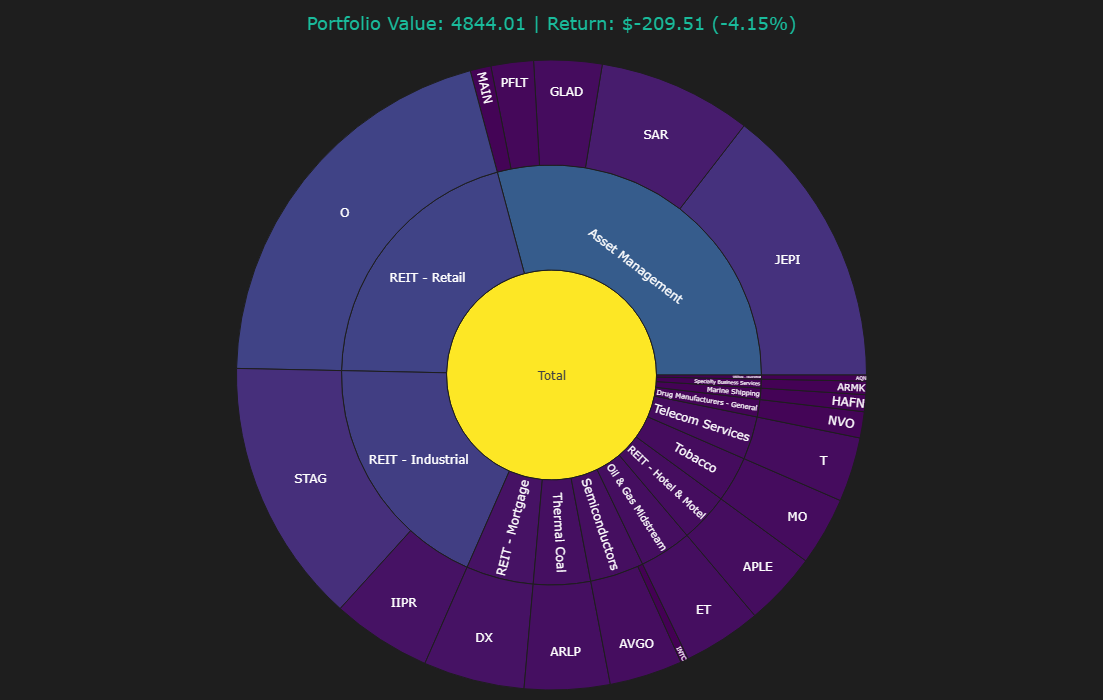

In [157]:
returns_str = f"${returns:,.2f}"
return_pct_str = f"{return_pct:.2f}%"

# Title string
chart_title = f"Portfolio Value: {curr_port_value_str} | Return: {returns_str} ({return_pct_str})"

# Define levels for the hierarchy in Sunburst
levels = ['Symbol', 'industry']  # From bottom to top
value_column = 'Equity'  # Column used for sizing and calculations
total_equity = master[value_column].sum()

def build_hierarchical_dataframe(master, levels, value_column):
    df_list = []
    for i, level in enumerate(levels):
        df_tree = pd.DataFrame(columns=['id', 'parent', 'value', '% of Portfolio', 'hover_text'])
        dfg = master.groupby(levels[i:]).sum(numeric_only=True).reset_index()
        df_tree['id'] = dfg[level].copy()
        if i < len(levels) - 1:
            df_tree['parent'] = dfg[levels[i+1]].copy()
        else:
            df_tree['parent'] = 'Total'
        df_tree['value'] = dfg[value_column]
        df_tree['% of Portfolio'] = ((df_tree['value'] / total_equity) * 100).round(1)
        df_tree['hover_text'] = (
            '<b>' + df_tree['id'] + '</b><br>' +
            'Equity: $' + df_tree['value'].apply(lambda x: f"{x:,.2f}") + '<br>' +
            '% of Portfolio: ' + df_tree['% of Portfolio'].astype(str) + '%'
        )
        df_list.append(df_tree)
    
    total = pd.Series({
        'id': 'Total',
        'parent': '',
        'value': total_equity,
        '% of Portfolio': 100.0,
        'hover_text': '<b>Total</b><br>Equity: $' + f"{total_equity:,.2f}" + '<br>% of Portfolio: 100.0%'
    })
    df_list.append(pd.DataFrame([total]))
    return pd.concat(df_list, ignore_index=True)

# Build the hierarchical DataFrame
df_all_trees = build_hierarchical_dataframe(master, levels, value_column)

# Create the Sunburst chart
sunburst_fig = go.Figure(go.Sunburst(
    labels=df_all_trees['id'],
    parents=df_all_trees['parent'],
    values=df_all_trees['value'],
    branchvalues='total',
    marker=dict(colors=df_all_trees['value'], colorscale='Viridis'),
    hoverinfo="text",
    textinfo="label",
    text=df_all_trees["hover_text"],
))

sunburst_fig.update_layout(
    title=dict(
        text=chart_title,
        font=dict(size=18, color=accent_color),
        x=0.5,
        xanchor='center'
    ),
    paper_bgcolor='#1e1e1e',
    plot_bgcolor='#1e1e1e',
    font_color=accent_color,
    margin=dict(t=60, b=10, r=10, l=10),  # Make room for the title
    height=700,
    width=700,
)

# Show chart
sunburst_fig.show()

# Dividend Bar Chart

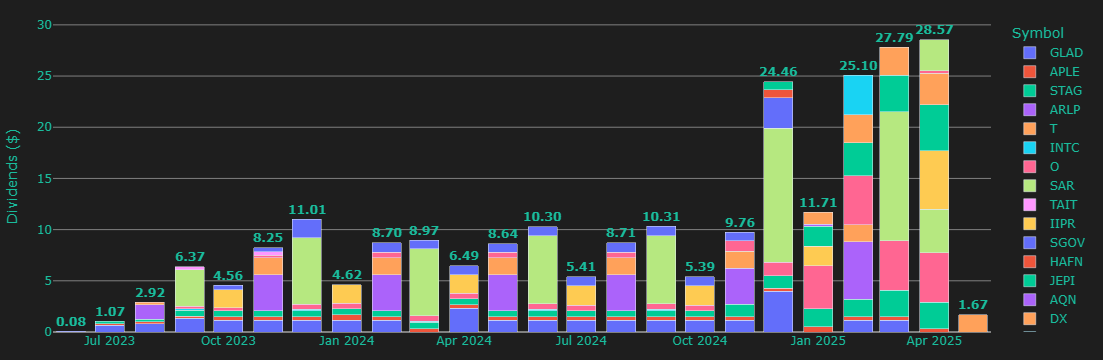

In [185]:
# 1. Convert the 'Date' column to datetime
dividends['Date'] = pd.to_datetime(dividends['Date'])

# 2. Create a 'YearMonth' column in the format 'YYYY-MM'
dividends['YearMonth'] = dividends['Date'].dt.strftime('%Y-%m')

# 3. Group the data by 'YearMonth' and 'Symbol' and sum the 'Dividend'
grouped_dividends = dividends.groupby(['YearMonth', 'Symbol'], as_index=False)['Dividend'].sum()

# Compute total dividend per YearMonth across all symbols
total_dividends = dividends.groupby('YearMonth', as_index=False)['Dividend'].sum()

# 4. Create a stacked bar chart using Plotly Express
fig_dividends = px.bar(
    grouped_dividends,
    x='YearMonth',
    y='Dividend',
    color='Symbol',
    title='',
    barmode='stack'
)

# 5. Add annotations for totals above each bar using the accent color and making the text bold
for i, row in total_dividends.iterrows():
    fig_dividends.add_annotation(
        x=row['YearMonth'],             # X-position at the corresponding YearMonth
        y=row['Dividend'],              # Y-position at the total dividend (stacked bar height)
        text=f"<b>{row['Dividend']:.2f}</b>",  # Bold text annotation
        showarrow=False,
        yshift=10,                      # Shift the text 10 pixels above the bar for clarity
        font=dict(
            color=accent_color,         # Use the accent color
            size=12
        ),
        align="center"
    )

# 6. Update the layout for a dark theme with smaller margins and no axis labels
fig_dividends.update_layout(
    paper_bgcolor='#1e1e1e',
    plot_bgcolor='#1e1e1e',
    font_color=accent_color,
    margin=dict(t=20, b=20, l=20, r=20),
    xaxis_title=None,  # remove x-axis label
    yaxis_title= 'Dividends ($)'   # remove y-axis label
)

# 7. Update axes:
#    - For the y-axis: add grid lines every 5 (colored gray) and ensure the zero line is gray.
#    - For the x-axis: remove additional gridlines and only show the zero line (colored gray).
fig_dividends.update_yaxes(dtick=5, gridcolor='gray', zeroline=True, zerolinecolor='gray')
fig_dividends.update_xaxes(showgrid=False, zeroline=True, zerolinecolor='gray')


# GENERATING STOCK CHART

In [188]:
def generate_stock_chart(symbol):
    """
    Given a stock symbol, generate an enhanced Plotly chart that includes:
      - Row 1: Price chart (Close, MA lines, Bollinger Bands)
      - Row 2: Spacer
      - Row 3: RSI indicator chart with horizontal dashed lines labeled 'Overbought' and 'Oversold'
      - Row 4: Volume bar chart
      - Row 5: MACD indicator chart (MACD, Signal Line, MACD Histogram)
      
    The traces are grouped by subplot using legendgroup so that the global legend shows
    extra vertical spacing between groups.
    """
    # Verify the symbol exists in our stored data
    if symbol not in symbol_dataframes:
        return {}

    # Prepare the dataframe (resetting the Date index)
    df = symbol_dataframes[symbol].reset_index()
    df['Date'] = pd.to_datetime(df['Date'])

    # Create subplots with 5 rows.
    fig = make_subplots(
        rows=5, cols=1,
        shared_xaxes=False,
        row_heights=[0.55, 0.02, 0.15, 0.14, 0.14],
        vertical_spacing=0.03,
        specs=[
            [{}],         # Row 1: Price
            [None],       # Row 2: Spacer
            [{}],         # Row 3: RSI
            [{}],         # Row 4: Volume
            [{}]          # Row 5: MACD
        ]
    )

    # --- Row 1: Price Chart (group "Price") ---
    fig.add_trace(
        go.Scatter(
            x=df['Date'],
            y=df['Close'],
            mode='lines',
            name="Close",
            legendgroup="Price",
            line=dict(color=accent_color, width=2)
        ),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=df['Date'],
            y=df['MA200'],
            mode='lines',
            name="MA200",
            legendgroup="Price",
            line=dict(color='orange', width=1.5)
        ),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=df['Date'],
            y=df['MA100'],
            mode='lines',
            name="MA100",
            legendgroup="Price",
            line=dict(color='green', width=1.5)
        ),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=df['Date'],
            y=df['MA50'],
            mode='lines',
            name="MA50",
            legendgroup="Price",
            line=dict(color='purple', width=1.5)
        ),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=df['Date'],
            y=df['BB200_Upper'],
            mode='lines',
            name="BB200 Upper",
            legendgroup="Price",
            line=dict(color='lightblue', dash='dot')
        ),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=df['Date'],
            y=df['BB200_Lower'],
            mode='lines',
            name="BB200 Lower",
            legendgroup="Price",
            line=dict(color='lightblue', dash='dot')
        ),
        row=1, col=1
    )

    # --- Horizontal dashed line for portfolio average cost (if available) ---
    if 'portfolio' in globals() and isinstance(portfolio, dict) and symbol in portfolio:
        port_data = portfolio[symbol]
        if port_data['shares'] > 0:
            avg_cost = port_data['cost'] / port_data['shares']
            annotation_text = f"#Avg Cost: {avg_cost:.2f}"
            fig.add_hline(
                y=avg_cost,
                line=dict(color="cyan", dash="dash", width=1),
                opacity=0.3,
                annotation_text=annotation_text,
                annotation_position="top left",
                annotation_font_size=10,
                row=1, col=1
            )

    # --- Row 1: Red 'X' markers for transactions (group "Price") ---
    if 'transactions' in globals():
        trans = transactions[transactions['Symbol'] == symbol].copy()
        if not trans.empty:
            trans['Date'] = pd.to_datetime(trans['Date'])
            trans['MatchedDate'] = trans['Date'].apply(lambda d: df.loc[df['Date'] >= d, 'Date'].min())
            matching_dates = trans['MatchedDate'].dropna().unique()
            matching_df = df[df['Date'].isin(matching_dates)]
            if not matching_df.empty:
                fig.add_trace(
                    go.Scatter(
                        x=matching_df['Date'],
                        y=matching_df['Close'],
                        mode='markers',
                        marker=dict(symbol='x', color='red', size=15, line=dict(width=2)),
                        name='Transaction',
                        legendgroup="Price"
                    ),
                    row=1, col=1
                )

    # --- Row 3: RSI Indicator (group "RSI") ---
    fig.add_trace(
        go.Scatter(
            x=df['Date'],
            y=df['RSI'],
            mode='lines',
            name="RSI",
            legendgroup="RSI",
            line=dict(color=accent_color, width=1.5)
        ),
        row=3, col=1
    )
    fig.add_hline(
        y=70,
        line=dict(color='grey', dash='dash'),
        annotation_text="Overbought",
        annotation_position="top left",
        annotation_font_color="grey",
        row=3, col=1
    )
    fig.add_hline(
        y=30,
        line=dict(color='grey', dash='dash'),
        annotation_text="Oversold",
        annotation_position="bottom left",
        annotation_font_color="grey",
        row=3, col=1
    )

    # --- Row 4: Volume Bars (group "Volume") ---
    fig.add_trace(
        go.Bar(
            x=df['Date'],
            y=df['Volume'],
            name="Volume",
            legendgroup="Volume",
            marker=dict(color=accent_color)
        ),
        row=4, col=1
    )

    # --- Row 5: MACD Indicator (group "MACD") ---
    fig.add_trace(
        go.Scatter(
            x=df['Date'],
            y=df['MACD'],
            mode='lines',
            name="MACD",
            legendgroup="MACD",
            line=dict(color='blue', width=1.5)
        ),
        row=5, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=df['Date'],
            y=df['Signal_Line'],
            mode='lines',
            name="Signal Line",
            legendgroup="MACD",
            line=dict(color='red', width=1.5)
        ),
        row=5, col=1
    )
    fig.add_trace(
        go.Bar(
            x=df['Date'],
            y=df['MACD_Histogram'],
            name="MACD Histogram",
            legendgroup="MACD",
            marker_color=['green' if val >= 0 else 'red' for val in df['MACD_Histogram']]
        ),
        row=5, col=1
    )
    fig.add_hline(
        y=0,
        line=dict(color='grey', dash='dash'),
        row=5, col=1
    )

    # --- Dropdown menu for date range selection ---
    max_date = df['Date'].max()
    six_months_date = max_date - pd.DateOffset(months=6)
    five_year_date = max_date - pd.DateOffset(years=5)

    max_date_str = max_date.strftime("%Y-%m-%d")
    six_months_str = six_months_date.strftime("%Y-%m-%d")
    five_year_str = five_year_date.strftime("%Y-%m-%d")

    updatemenus = [
        dict(
            buttons=list([
                dict(label="6M", method="relayout", args=[{"xaxis.range": [six_months_str, max_date_str]}]),
                dict(label="5Y", method="relayout", args=[{"xaxis.range": [five_year_str, max_date_str]}]),
            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.0, xanchor="left",
            y=1.1, yanchor="top"
        )
    ]
    fig.update_layout(updatemenus=updatemenus)

    # --- Layout Adjustments ---
    fig.update_xaxes(title_text="", row=1, col=1)
    fig.update_xaxes(matches='x', row=3, col=1, showticklabels=False)
    fig.update_xaxes(matches='x', row=4, col=1, showticklabels=False)
    fig.update_xaxes(matches='x', row=5, col=1, showticklabels=False)

    fig.update_yaxes(title_text="Price ($)", row=1, col=1)
    fig.update_yaxes(title_text="RSI", row=3, col=1)
    fig.update_yaxes(title_text="Volume", row=4, col=1)
    fig.update_yaxes(title_text="MACD", row=5, col=1)

    fig.add_annotation(
        dict(
            x=0.5,
            y=1.05,
            xref="paper",
            yref="paper",
            text=f"{symbol} Stock Price",
            showarrow=False,
            font=dict(size=16, color=accent_color)
        )
    )

    fig.update_layout(
        template="plotly_dark",
        paper_bgcolor='#1e1e1e',
        plot_bgcolor='#1e1e1e',
        font_color=accent_color,
        margin=dict(t=20, b=20, r=20, l=20),
        height=900
    )

    # Ensure volume bars display correctly
    fig.update_traces(marker_line_color=accent_color, selector=dict(type='bar'))


    
    # --- Update the Global Legend (only the modified section) ---
    fig.update_layout(
        legend=dict(
            traceorder='grouped',
            tracegroupgap=10,  # Base gap between groups
            orientation='v',
            x=1.02,
            y=1
        )
    )



    return fig

# GENERATING WATCHLIST FUNCTION

In [191]:
def generate_stock_chart1(symbol, data_dict, title_prefix=""):
    """
    Given a stock symbol and a data dictionary, generate an enhanced Plotly chart with:
      - Row 1: Price chart (Close, MA lines, Bollinger Bands)
      - Row 3: RSI indicator (with Overbought/Oversold lines)
      - Row 4: Volume bar chart
      - Row 5: MACD indicator (MACD, Signal Line, MACD Histogram)
    
    The title_prefix is prepended to the chart title.
    """
    if symbol not in data_dict:
        print(f"Data for {symbol} not found.")
        return {}
    
    # Prepare DataFrame
    df = data_dict[symbol].reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Create subplots with 5 rows
    fig = make_subplots(
        rows=5, cols=1,
        shared_xaxes=False,
        row_heights=[0.55, 0.02, 0.15, 0.14, 0.14],
        vertical_spacing=0.03,
        specs=[[{}], [None], [{}], [{}], [{}]]
    )
    
    # --- Row 1: Price Chart ---
    fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], mode='lines', name="Close",
                             legendgroup="Price",
                             line=dict(color=accent_color, width=2)), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['Date'], y=df['MA200'], mode='lines', name="MA200",
                             legendgroup="Price",
                             line=dict(color='orange', width=1.5)), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['Date'], y=df['MA100'], mode='lines', name="MA100",
                             legendgroup="Price",
                             line=dict(color='green', width=1.5)), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['Date'], y=df['MA50'], mode='lines', name="MA50",
                             legendgroup="Price",
                             line=dict(color='purple', width=1.5)), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['Date'], y=df['BB200_Upper'], mode='lines', name="BB200 Upper",
                             legendgroup="Price",
                             line=dict(color='lightblue', dash='dot')), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['Date'], y=df['BB200_Lower'], mode='lines', name="BB200 Lower",
                             legendgroup="Price",
                             line=dict(color='lightblue', dash='dot')), row=1, col=1)
    
    # --- Row 3: RSI Indicator ---
    fig.add_trace(go.Scatter(x=df['Date'], y=df['RSI'], mode='lines', name="RSI",
                             legendgroup="RSI",
                             line=dict(color=accent_color, width=1.5)), row=3, col=1)
    fig.add_hline(y=70, line=dict(color='grey', dash='dash'),
                  annotation_text="Overbought", annotation_position="top left",
                  annotation_font_color="grey", row=3, col=1)
    fig.add_hline(y=30, line=dict(color='grey', dash='dash'),
                  annotation_text="Oversold", annotation_position="bottom left",
                  annotation_font_color="grey", row=3, col=1)
    
    # --- Row 4: Volume Bar Chart ---
    fig.add_trace(go.Bar(x=df['Date'], y=df['Volume'], name="Volume",
                         legendgroup="Volume",
                         marker=dict(color=accent_color)), row=4, col=1)
    
    # --- Row 5: MACD Indicator ---
    fig.add_trace(go.Scatter(x=df['Date'], y=df['MACD'], mode='lines', name="MACD",
                             legendgroup="MACD",
                             line=dict(color='blue', width=1.5)), row=5, col=1)
    fig.add_trace(go.Scatter(x=df['Date'], y=df['Signal_Line'], mode='lines', name="Signal Line",
                             legendgroup="MACD",
                             line=dict(color='red', width=1.5)), row=5, col=1)
    fig.add_trace(go.Bar(x=df['Date'], y=df['MACD_Histogram'], name="MACD Histogram",
                         legendgroup="MACD",
                         marker_color=['green' if val >= 0 else 'red' for val in df['MACD_Histogram']]),
                  row=5, col=1)
    fig.add_hline(y=0, line=dict(color='grey', dash='dash'), row=5, col=1)
    
    # --- Dropdown Menu for Date Range ---
    max_date = df['Date'].max()
    if pd.isnull(max_date):
        max_date = pd.Timestamp.today()
    six_months_date = max_date - pd.DateOffset(months=6)
    five_year_date = max_date - pd.DateOffset(years=5)
    max_date_str = max_date.strftime("%Y-%m-%d")
    six_months_str = six_months_date.strftime("%Y-%m-%d")
    five_year_str = five_year_date.strftime("%Y-%m-%d")
    updatemenus = [dict(
        buttons=[
            dict(label="6M", method="relayout", args=[{"xaxis.range": [six_months_str, max_date_str]}]),
            dict(label="5Y", method="relayout", args=[{"xaxis.range": [five_year_str, max_date_str]}]),
        ],
        direction="down",
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0.0, xanchor="left",
        y=1.1, yanchor="top"
    )]
    fig.update_layout(updatemenus=updatemenus)
    
    # --- Layout Adjustments ---
    fig.update_xaxes(title_text="", row=1, col=1)
    fig.update_xaxes(matches='x', row=3, col=1, showticklabels=False)
    fig.update_xaxes(matches='x', row=4, col=1, showticklabels=False)
    fig.update_xaxes(matches='x', row=5, col=1, showticklabels=False)
    fig.update_yaxes(title_text="Price ($)", row=1, col=1)
    fig.update_yaxes(title_text="RSI", row=3, col=1)
    fig.update_yaxes(title_text="Volume", row=4, col=1)
    fig.update_yaxes(title_text="MACD", row=5, col=1)
    
    fig.add_annotation(dict(
        x=0.5,
        y=1.05,
        xref="paper",
        yref="paper",
        text=f"{title_prefix}{symbol} Stock Price",
        showarrow=False,
        font=dict(size=16, color=accent_color)
    ))
    
    fig.update_layout(template="plotly_dark", paper_bgcolor='#1e1e1e', plot_bgcolor='#1e1e1e',
                      font_color=accent_color, margin=dict(t=20, b=20, r=20, l=20), height=900,
                      legend=dict(traceorder='grouped', tracegroupgap=10, orientation='v', x=1.02, y=1))
    fig.update_traces(marker_line_color=accent_color, selector=dict(type='bar'))
    
    return fig

# Generating Portfolio Value

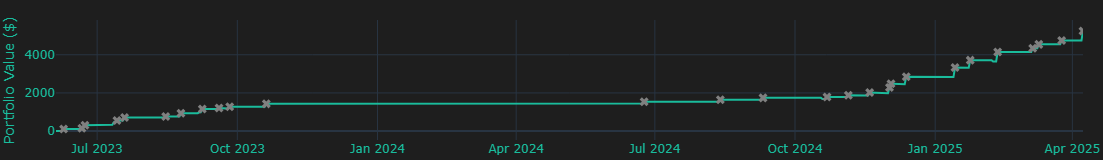

In [194]:


# --- 1. Prepare Daily Data ---

# Ensure the Date column is datetime and sort transactions
transactions['Date'] = pd.to_datetime(transactions['Date'])
transactions = transactions.sort_values('Date').reset_index(drop=True)

# Make sure each symbol’s DataFrame index is datetime
for symbol, df in symbol_dataframes.items():
    symbol_dataframes[symbol].index = pd.to_datetime(df.index)

# Define simulation start and end dates.
start_date = transactions['Date'].min()
max_market_date = max(df.index.max() for df in symbol_dataframes.values())
end_date = max(transactions['Date'].max(), max_market_date)
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex each symbol’s DataFrame to daily frequency (forward–fill missing data)
daily_symbol_prices = {}
for symbol, df in symbol_dataframes.items():
    df = df.sort_index()
    df_daily = df.reindex(all_dates, method='ffill')
    daily_symbol_prices[symbol] = df_daily

# --- 2. Daily Portfolio Simulation ---

# Prepare a DataFrame to hold the daily simulation results.
daily_sim = pd.DataFrame(index=all_dates)
daily_sim['Cash'] = np.nan
daily_sim['MarketValue'] = np.nan
daily_sim['PortfolioValue'] = np.nan
daily_sim['CumulativeDeposits'] = np.nan

# Initialize portfolio variables.
cash1 = 0
cumulative_deposits = 0
portfolio_positions = {}  # e.g., {'AAPL': 50, 'MSFT': 20, ...}

# Lists to store deposit dates and portfolio values at deposit days.
deposit_dates = []
deposit_portfolio_values = []

# Group transactions by date for faster lookup.
transactions_grouped = transactions.groupby('Date')

# Loop through each day in the date range.
for date in all_dates:
    # Process any transactions on this day.
    if date in transactions_grouped.groups:
        day_transactions = transactions_grouped.get_group(date)
        for _, row in day_transactions.iterrows():
            symbol = row['Symbol']
            bs = row['Buy_sell']
            if bs == 'Deposit':
                cash1 += row['Amount']
                cumulative_deposits += row['Amount']
                # Record the deposit date.
                deposit_dates.append(date)
            elif bs == 'Buy':
                cash1 -= row['Amount']  # Deduct purchase cost.
                portfolio_positions[symbol] = portfolio_positions.get(symbol, 0) + row['Shares']
            elif bs == 'Sell':
                cash1 += row['Amount']  # Add sale proceeds.
                portfolio_positions[symbol] = portfolio_positions.get(symbol, 0) - row['Shares']
    
    # Compute market value for the day using that day’s prices.
    market_value = 0
    for symbol, qty in portfolio_positions.items():
        if symbol in daily_symbol_prices:
            price = daily_symbol_prices[symbol].loc[date, 'Close']
            market_value += qty * price

    # Compute total portfolio value: cash1 + market value.
    portfolio_value = cash1 + market_value

    # Save the daily results.
    daily_sim.loc[date, 'Cash'] = cash1
    daily_sim.loc[date, 'MarketValue'] = market_value
    daily_sim.loc[date, 'PortfolioValue'] = portfolio_value
    daily_sim.loc[date, 'CumulativeDeposits'] = cumulative_deposits

    # If today is a deposit day, record the portfolio value for that day.
    if date in deposit_dates:
        deposit_portfolio_values.append(portfolio_value)

# --- 3. Plot Daily Portfolio Value with Deposit Markers ---

# Base trace: Plot every day's portfolio value (points and connecting lines)


# Define desired figure dimensions
figure_width = 700  # pixels
figure_height = 160  # pixels


fig1 = go.Figure()

fig1.add_trace(
    go.Scatter(
        x=daily_sim.index,
        y=daily_sim['PortfolioValue'],
        mode='lines',  # Points for every day with connecting lines
        line=dict(color=accent_color),
        name='Portfolio Value'
    )
)

# Additional trace: Mark deposit days with a grey "x"
fig1.add_trace(
    go.Scatter(
        x=deposit_dates,
        y=deposit_portfolio_values,
        mode='markers',
        marker=dict(symbol='x', size=8, color='grey'),
        name='Deposit'
    )
)

fig1.update_layout(
    xaxis=dict(
         range=[daily_sim.index[0], daily_sim.index[-1]],  # force the range to start at your first date
         anchor='y',
         position=0,       # position the x-axis at 0 (left side of the plotting area)
         automargin=True,  # ensure margins adjust automatically (or set margin.l=0 in layout if needed)
    ),
    width=figure_width,
    height=figure_height,
    yaxis_title="Portfolio Value ($)",
    template="plotly_dark",
    font=dict(color=accent_color),
    paper_bgcolor='#1e1e1e',
    plot_bgcolor='#1e1e1e',
    showlegend=False,
    margin=dict(l=0, r=20, t=20, b=20)  # setting left margin to 0 can help align the first x value with the y-axis
)





fig1.show()

# Returns

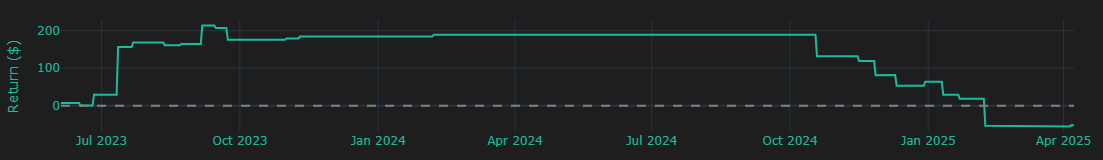

In [197]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Ensure transaction dates are in datetime format and sort them
transactions['Date'] = pd.to_datetime(transactions['Date'])
transactions = transactions.sort_values('Date').reset_index(drop=True)

# Convert index of each symbol's DataFrame to datetime
for symbol, df in symbol_dataframes.items():
    df.index = pd.to_datetime(df.index)

# Create a daily date range for the simulation period
start_date = transactions['Date'].min()
max_market_date = max(df.index.max() for df in symbol_dataframes.values())
end_date = max(transactions['Date'].max(), max_market_date)
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex symbol data to daily frequency with forward fill
daily_symbol_prices = {}
for symbol, df in symbol_dataframes.items():
    df = df.sort_index()
    df_daily = df.reindex(all_dates, method='ffill')
    daily_symbol_prices[symbol] = df_daily

# Initialize the DataFrame to hold daily simulation results
daily_sim = pd.DataFrame(index=all_dates)
daily_sim['Cash'] = np.nan
daily_sim['MarketValue'] = np.nan
daily_sim['TotalReturns'] = np.nan
daily_sim['CumulativeDeposits'] = np.nan
daily_sim['NetReturns'] = np.nan

# Initialize portfolio variables
cash1 = 0
cumulative_deposits = 0
portfolio_positions = {}

# Group transactions by date
transactions_grouped = transactions.groupby('Date')

# Iterate over each date in the simulation period
for date in all_dates:
    # Process transactions for the current date
    if date in transactions_grouped.groups:
        day_transactions = transactions_grouped.get_group(date)
        for _, row in day_transactions.iterrows():
            symbol = row['Symbol']
            action = row['Buy_sell']
            if action == 'Deposit':
                cash1 += row['Amount']
                cumulative_deposits += row['Amount']
            elif action == 'Buy':
                cash1 -= row['Amount']
                portfolio_positions[symbol] = portfolio_positions.get(symbol, 0) + row['Shares']
            elif action == 'Sell':
                cash1 += row['Amount']
                portfolio_positions[symbol] = portfolio_positions.get(symbol, 0) - row['Shares']
    
    # Calculate market value of current holdings
    market_value = 0
    for symbol, qty in portfolio_positions.items():
        if symbol in daily_symbol_prices:
            price = daily_symbol_prices[symbol].loc[date, 'Close']
            market_value += qty * price

    total_returns = cash1 + market_value
    net_returns = total_returns - cumulative_deposits

    # Record daily values
    daily_sim.loc[date, 'Cash'] = cash1
    daily_sim.loc[date, 'MarketValue'] = market_value
    daily_sim.loc[date, 'TotalReturns'] = total_returns
    daily_sim.loc[date, 'CumulativeDeposits'] = cumulative_deposits
    daily_sim.loc[date, 'NetReturns'] = net_returns

import plotly.graph_objects as go

# === 5. Plot Daily Net Returns with Plotly ===

# Define desired figure dimensions
figure_width = 700  # pixels
figure_height = 160  # pixels

# Create a new figure
fig2 = go.Figure()

# Plot the daily net returns as a line
fig2.add_trace(
    go.Scatter(
        x=daily_sim.index,
        y=daily_sim['NetReturns'],
        mode='lines',
        line=dict(color=accent_color),
        name='Net Returns'
    )
)

# Add a horizontal line at 0 (break-even level)
fig2.add_hline(
    y=0,
    line=dict(color='grey', dash='dash'),
    #annotation_text='0 Baseline',
    #annotation_position='bottom right'
)

# Update layout for better visualization
fig2.update_layout(
    width=figure_width,       # Set the figure width
    height=figure_height,     # Set the figure height
    yaxis_title="Return ($)",
    template="plotly_dark",
    showlegend=False,
    font=dict(color=accent_color),
    paper_bgcolor='#1e1e1e',
    plot_bgcolor='#1e1e1e',
    margin=dict(l=20, r=20, t=20, b=20)  # Adjust margins (left, right, top, bottom)
)

# Display the interactive figure
fig2.show()



# MAIN DISPLAY 

In [200]:
import socket
from dash import dcc, html, dash_table, Dash
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

# -----------------------------------------------------------------------------
# Helper function to get a free port
# -----------------------------------------------------------------------------
def get_free_port():
    """Finds a free port on localhost."""
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.bind(('127.0.0.1', 0))
    addr, port = s.getsockname()
    s.close()
    return port

# -----------------------------------------------------------------------------
# Attempt to terminate any existing app instance (if defined)
# -----------------------------------------------------------------------------
# if 'app' in globals():
#     try:
#         app._terminate()  # JupyterDash provides this method to clean up the server
#     except Exception as e:
#         print("Error terminating previous instance:", e)

# -----------------------------------------------------------------------------
# Dynamically get a free port
# -----------------------------------------------------------------------------
port = get_free_port()

# -----------------------------------------------------------------------------
# Create a new Dash app instance
# -----------------------------------------------------------------------------
app = Dash(__name__)

# -----------------------------------------------------------------------------
# Define color theme settings
# -----------------------------------------------------------------------------
accent_color = '#1abc9c'  # Fresh teal accent
panel_bg     = '#222222'  # Panel background
header_bg    = '#333333'  # Table header background
cell_bg      = '#262626'  # Table cell background

# -----------------------------------------------------------------------------
# Prepare the table data from the master DataFrame.
# (Assumes 'master' already contains the required columns.)
table_data = master[top_columns].copy()

# -----------------------------------------------------------------------------
# Define the app layout
# -----------------------------------------------------------------------------
app.layout = html.Div(
    style={
        'backgroundColor': 'black',
        'color': 'white',
        'fontFamily': "'Montserrat', sans-serif",
        'padding': '20px',
        'minHeight': '100vh',
        'display': 'flex',
        'flexDirection': 'column',
        'alignItems': 'center',
    },
    children=[
        # Main Title
        html.H1(
            "Otica",
            style={
                'textAlign': 'center',
                'color': accent_color,
                'fontSize': '2.8em',
                'marginBottom': '20px',
                'width': '100%',
            },
        ),
        # Banner with Total Invested and Portfolio Value
        html.Div(
            style={
                'width': '100%',
                'maxWidth': '1200px',
                'display': 'flex',
                'justifyContent': 'space-around',
                'alignItems': 'center',
                'marginBottom': '20px',
                'padding': '10px',
                'backgroundColor': panel_bg,
                'borderRadius': '15px',
                'boxShadow': '0px 4px 10px rgba(0, 0, 0, 0.5)',
            },
            children=[
                html.Div(
                    f"Total: {total}",
                    style={'fontSize': '1.5em', 'color': accent_color}
                ),
                 html.Div(
                    f"Cash: {cash}",
                    style={'fontSize': '1.5em', 'color': accent_color}
                ),
                html.Div(
                    f"Portfolio Value: {curr_port_value_str}",
                    style={'fontSize': '1.5em', 'color': accent_color}
                ),
                html.Div(
                    f"Returns: {returns}",
                    style={'fontSize': '1.5em', 'color': accent_color}
                ),
                html.Div(
                    f"Return %: {return_pct}",
                    style={'fontSize': '1.5em', 'color': accent_color}
                ),
            ]
        ),
        ###ADJUSTMENTS: New top banner layout with sunburst on left and two charts (without titles) on the right.
        html.Div(
            style={
                'display': 'flex',
                'width': '100%',
                'maxWidth': '1200px',
                'marginBottom': '20px',
                'gap': '20px',
            },


            
            children=[
                # Sunburst Chart Container (smaller and with reduced height)
                html.Div(
                    style={
                        'width': '490px',
                        'height': '360px',  # reduced container height
                        'backgroundColor': panel_bg,
                        'borderRadius': '15px',
                        'padding': '10px',  # reduced padding if needed
                        'boxShadow': '0px 4px 10px rgba(0, 0, 0, 0.5)',
                        'display': 'flex',
                        'justifyContent': 'center',
                        'alignItems': 'center',
                    },
                    children=[
                        dcc.Graph(
                            id='sunburst-chart',
                            figure=sunburst_fig.update_layout(
                                paper_bgcolor='#1e1e1e',
                                plot_bgcolor='#1e1e1e',
                                font_color='white',
                                margin=dict(t=10, b=10, r=10, l=10),
                                height=420,  # reduced to fit container
                                width=410
                            ),
                            style={'margin': '0 auto'},
                        ),
                    ],
                ),


                
                # Statistics Banner Container (split vertically into two equal charts, no titles)
                html.Div(
                    style={
                        'flex': '1',
                        'display': 'flex',
                        'flexDirection': 'column',
                        'gap': '20px',
                    },
                    children=[
                        # Top half: Figure One - Cumulative Daily Returns (Detailed) without title
                        html.Div(
                            style={
                                'backgroundColor': panel_bg,
                                'borderRadius': '15px',
                                'padding': '10px',
                                'boxShadow': '0px 4px 10px rgba(0, 0, 0, 0.5)',
                                'height': '160px',
                            },
                            children=[
                                dcc.Graph(
                                    id='detailed-returns-chart',
                                    figure=fig1,
                                    style={'width': '100%', 'height': '300px'},
                                ),
                            ],
                        ),
                        # Bottom half: Figure Two - Cumulative Daily Returns Over Time (Optimized) without title
                        html.Div(
                            style={
                                'backgroundColor': panel_bg,
                                'borderRadius': '15px',
                                'padding': '10px',
                                'boxShadow': '0px 4px 10px rgba(0, 0, 0, 0.5)',
                                'height': '160px',
                            },
                            children=[
                                dcc.Graph(
                                    id='returns-chart',
                                    figure=fig2,
                                    style={'width': '100%', 'height': '300px'},
                                ),
                            ],
                        ),
                    ],
                ),
            ],
        ),
        # -----------------------------------------------------------------------------
        # Dividends Chart Section
        # -----------------------------------------------------------------------------
        html.Div(
            style={
                'backgroundColor': panel_bg,
                'borderRadius': '15px',
                'padding': '20px',
                'boxShadow': '0px 4px 10px rgba(0, 0, 0, 0.5)',
                'width': '100%',
                'maxWidth': '1200px',
                'marginBottom': '20px'
            },
            children=[
                html.H3(
                    "Dividends",
                    style={'textAlign': 'center', 'color': accent_color, 'marginBottom': '8px'},
                ),
                dcc.Graph(
                    id='dividend-chart',
                    figure=fig_dividends,
                    style={'width': '100%', 'height': '500px'},
                ),
            ],
        ),
        # -----------------------------------------------------------------------------
        # Stock Chart Section
        # -----------------------------------------------------------------------------
        html.Div(
            style={
                'backgroundColor': panel_bg,
                'borderRadius': '15px',
                'padding': '20px',
                'boxShadow': '0px 4px 10px rgba(0, 0, 0, 0.5)',
                'width': '100%',
                'maxWidth': '1200px',
                'marginBottom': '20px',
            },
            children=[
                # Dropdown Container
                html.Div(
                    style={
                        'display': 'flex',
                        'justifyContent': 'center',
                        'marginBottom': '20px'
                    },
                    children=[
                        dcc.Dropdown(
                            id='symbol-dropdown',
                            options=[{'label': symbol, 'value': symbol} for symbol in symbol_dataframes.keys()],
                            value=list(symbol_dataframes.keys())[0],
                            clearable=False,
                            style={
                                'width': '100%',
                                'borderRadius': '5px',
                                'backgroundColor': 'black',
                                'color': 'black'
                            }
                        ),
                    ]
                ),
                # Stock Chart Graph with increased height
                dcc.Graph(
                    id='stock-chart',
                    style={'width': '100%', 'height': '900px'},
                ),
            ],
        ),
        # -----------------------------------------------------------------------------
        # Portfolio Details Table Section
        # -----------------------------------------------------------------------------
        html.Div(
            style={
                'backgroundColor': panel_bg,
                'borderRadius': '15px',
                'padding': '20px',
                'boxShadow': '0px 4px 10px rgba(0, 0, 0, 0.5)',
                'width': '100%',
                'maxWidth': '1200px',
            },
            children=[
                html.H3(
                    "Portfolio Details",
                    style={'textAlign': 'center', 'color': accent_color, 'marginBottom': '10px'},
                ),
                

                dash_table.DataTable(
                    id='portfolio-table',
                    columns=[{"name": col, "id": col, "type": "numeric" if pd.api.types.is_numeric_dtype(table_data[col]) else "text"}
                             for col in table_data.columns],
                    data=table_data.to_dict('records'),
                    style_table={
                        'margin': 'auto',
                        'width': '100%',
                        'borderRadius': '10px',
                        'overflowX': 'auto'  # Enable horizontal scroll
                    },
                    style_header={
                        'backgroundColor': header_bg,
                        'color': 'white',
                        'fontWeight': 'bold',
                        'fontSize': '1.1em',
                        'border': 'none',
                        'borderBottom': f'2px solid {accent_color}'
                    },
                    style_cell={
                        'backgroundColor': cell_bg,
                        'color': 'white',  # Default all cell text to white
                        'textAlign': 'center',
                        'border': 'none',
                        'padding': '8px',
                        'minWidth': '120px', 'width': '120px', 'maxWidth': '120px',  # consistent column widths
                        'overflow': 'hidden',
                        'textOverflow': 'ellipsis',
                    },
                    style_data={
                        'border': 'none',
                        'fontSize': '1em'
                    },
                    style_data_conditional=[
                        {'if': {'row_index': 'odd'}, 'backgroundColor': panel_bg},
                        {'if': {'state': 'active'}, 'backgroundColor': '#424242',
                         'border': f'1px solid {accent_color}'},
                
                        # Only apply red/green to "Total Return %" column
                        {
                            'if': {
                                'filter_query': '{Total Return %} < 0',
                                'column_id': 'Total Return %'
                            },
                            'color': 'red'
                        },
                        {
                            'if': {
                                'filter_query': '{Total Return %} > 0',
                                'column_id': 'Total Return %'
                            },
                            'color': 'green'
                        },
                    ],
                ),


                
            ],
        ),
        # -----------------------------------------------------------------------------
        # Add Watchlist Visualization Section here (NEW)
        # -----------------------------------------------------------------------------
        html.Div(
            style={
                'backgroundColor': panel_bg,
                'borderRadius': '15px',
                'padding': '20px',
                'boxShadow': '0px 4px 10px rgba(0, 0, 0, 0.5)',
                'width': '100%',
                'maxWidth': '1200px',
                'marginBottom': '20px',
            },
            children=[
                html.H3(
                    "Watchlist Visualization",
                    style={'textAlign': 'center', 'color': accent_color, 'marginBottom': '10px'}
                ),
                dcc.Dropdown(
                    id='watchlist-dropdown',
                    options=[{'label': symbol, 'value': symbol} for symbol in symbols1],
                    value=symbols1[0],
                    clearable=False,
                    style={
                        'width': '100%',
                        'borderRadius': '5px',
                        'backgroundColor': 'black',
                        'color': 'black'
                    }
                ),
                dcc.Graph(
                    id='watchlist-chart',
                    style={'width': '100%', 'height': '900px'}
                ),
            ]
        ),
    ]
)

# -----------------------------------------------------------------------------
# Callback to update the stock chart based on the dropdown selection (Main Stock Chart)
# -----------------------------------------------------------------------------
@app.callback(
    Output('stock-chart', 'figure'),
    [Input('symbol-dropdown', 'value')]
)
def update_stock_chart(symbol):
    return generate_stock_chart(symbol)

# -----------------------------------------------------------------------------
# Callback to update the Watchlist Visualization based on the dropdown selection
# -----------------------------------------------------------------------------
@app.callback(
    Output('watchlist-chart', 'figure'),
    [Input('watchlist-dropdown', 'value')]
)
def update_watchlist_chart(symbol):
    return generate_stock_chart1(symbol, symbol_dataframes1, title_prefix="Watchlist: ")

# -----------------------------------------------------------------------------
# Run the app inline in the notebook using the dynamically selected port.
# -----------------------------------------------------------------------------
app.run_server(mode='inline', debug=True, port=port)
print(f"Your app is available at: http://127.0.0.1:{port}")


Your app is available at: http://127.0.0.1:52154


In [ ]:
# reutrn (equity, Total Return %, # Shares

In [206]:
master

,Name,Symbol,Shares,Price,Average cost,Return,Equity,Return %,Portfolio %,Total_Div,...,technical_score_description,Fundamental_Signal,Technical_Signal,Composite_Action,industry.1,industryKey.1,industryDisp.1,sector.1,sectorKey.1,sectorDisp.1
0,AT&T,T,6,26.78,15.17,69.66,160.68,76.5,3.3,11.97,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
1,Alliance Resource,ARLP,8,26.55,22.63,31.38,212.40,17.3,4.4,24.50,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
2,Gladstone Capital,GLAD,7,24.15,20.05,28.71,169.05,20.4,3.5,25.45,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
3,Broadcom,AVGO,1,181.60,164.30,17.30,181.60,10.5,3.7,0.00,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
4,Altria,MO,3,56.84,51.45,16.18,170.52,10.5,3.5,6.12,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
5,Realty Income,O,18,55.20,54.87,6.03,993.60,0.6,20.5,27.48,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
6,Algonquin Power & Utilities,AQN,3,5.04,4.79,0.75,15.12,5.2,0.3,0.17,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
7,Aramark,ARMK,1,33.13,33.85,-0.72,33.13,-2.1,0.7,0.00,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
8,PennantPark Floating Rate,PFLT,11,9.60,9.79,-2.10,105.60,-1.9,2.2,0.00,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN
9,Novo Nordisk,NVO,1,65.00,67.64,-2.64,65.00,-3.9,1.3,0.00,...,This score is derived from technical indicator...,Sell,Hold,Sell,NaN,NaN,NaN,NaN,NaN,NaN


In [216]:
master.columns

Index(['Name', 'Symbol', 'Shares', 'Price', 'Average cost', 'Return', 'Equity',
       'Return %', 'Portfolio %', 'Total_Div',
       ...
       'technical_score_description', 'Fundamental_Signal', 'Technical_Signal',
       'Composite_Action', 'industry.1', 'industryKey.1', 'industryDisp.1',
       'sector.1', 'sectorKey.1', 'sectorDisp.1'],
      dtype='object', length=265)

In [220]:
master[['Name', 'Symbol', 'Shares', 'dividendYield', 'Div_Freq', 'Average cost', 'Price', 'Return %']]

,Name,Symbol,Shares,dividendYield,Div_Freq,Average cost,Price,Return %
0,AT&T,T,6,4.14,Q,15.17,26.78,76.5
1,Alliance Resource,ARLP,8,10.74,Q,22.63,26.55,17.3
2,Gladstone Capital,GLAD,7,8.20,M,20.05,24.15,20.4
3,Broadcom,AVGO,1,1.30,NaN,164.30,181.60,10.5
4,Altria,MO,3,7.20,Q,51.45,56.84,10.5
5,Realty Income,O,18,5.83,M,54.87,55.20,0.6
6,Algonquin Power & Utilities,AQN,3,5.16,Q,4.79,5.04,5.2
7,Aramark,ARMK,1,1.27,NaN,33.85,33.13,-2.1
8,PennantPark Floating Rate,PFLT,11,12.92,NaN,9.79,9.60,-1.9
9,Novo Nordisk,NVO,1,2.50,NaN,67.64,65.00,-3.9
